# Health Insurance Cross Sell Prediction

https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction/data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR
# from xgboost import XGBRegressor
# import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats

# from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import optuna

%matplotlib inline

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)

random_state = 42

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Загружаем датафрейм
train = pd.read_csv(
    r"C:\Users\Александр\OneDrive\Python\Python projects\020_ML practice\Health Insurance Cross Sell Prediction\train.csv",
    index_col=0)
test = pd.read_csv(
    r"C:\Users\Александр\OneDrive\Python\Python projects\020_ML practice\Health Insurance Cross Sell Prediction\test.csv",
    index_col=0)

train.shape, test.shape

((381109, 11), (127037, 10))

## Общая информация о датасетах

**Описание фичей**
- id: Unique ID for the customer
- Gender: Gender of the customer
- Age: Age of the customer
- Driving_License	0 : Customer does not have DL, 1 : Customer already has DL
- Region_Code: Unique code for the region of the customer
- Previously_Insured 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
- Vehicle_Age: Age of the Vehicle
- Vehicle_Damage 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
- Annual_Premium: The amount customer needs to pay as premium in the year
- Policy_Sales_Channel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- Vintage: Number of Days, Customer has been associated with the company
- Response 1 : Customer is interested, 0 : Customer is not interested

In [3]:
# Проводим быстрый EDA c помощью pandas_profiling:

profile = ProfileReport(train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Функция для общей информации по датафрейму
def get_skew_kurt(df):
    skew_v = df.skew().sort_values(ascending=False)
    kurt_v = df.kurtosis()
    df_skew_kurt = pd.concat([skew_v, kurt_v],
                             axis=1,
                             keys=['Skewness', 'Kurtosis'])
    return df_skew_kurt.head(10)


# Общая информация
def information(df: 'DataFrame', name: 'str') -> None:
    '''Функция напечатает информацию по датасету: первые три строки,
    название столбцов, кол-во строк и их тип, кол-во пропущенных значений,
    разброс, среднее, медиану, макс и мин значения, полные дубликаты и 
    уникальные значения'''
    print('*' * 30, name, '*' * 30)
    print()
    display(df.head(3))
    print('-' * 25, 'INFO', '-' * 25)
    print()
    print(df.info())
    print()
    print('-' * 10, 'NAN', '-' * 10)
    print()
    print(df.isna().sum())
    print()
    print('-' * 5, 'DESCRIBE', '-' * 5)
    print(df.describe())
    print()
    print('-' * 5, 'SKEWNESS & KURTOSIS', '-' * 5)
    print(get_skew_kurt(df))
    print()
    print('-' * 5, 'DUPLICATED', '-' * 5)
    print(df.duplicated().sum())
    print()
    print('-' * 25, 'UNIQUE VALUES', '-' * 25)
    for column in df.columns:
        print(column)
        print(df[column].unique())
        print(df[column].dtype)
        print('+' * 25)

In [5]:
information(train, "Train Data Frame")

****************************** Train Data Frame ******************************



,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.000,0,> 2 Years,Yes,40454.000,26.000,217,1
2,Male,76,1,3.000,0,1-2 Year,No,33536.000,26.000,183,0
3,Male,47,1,28.000,0,> 2 Years,Yes,38294.000,26.000,27,1


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 43.0+ MB
None

---------- NAN ----------

Gender                  0
Age                     0
Driving

In [6]:
information(test, "Test Data Frame")

****************************** Test Data Frame ******************************



,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
381110,Male,25,1,11.000,1,< 1 Year,No,35786.000,152.000,53
381111,Male,40,1,28.000,0,1-2 Year,Yes,33762.000,7.000,111
381112,Male,47,1,28.000,0,1-2 Year,Yes,40050.000,124.000,199


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127037 entries, 381110 to 508146
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                127037 non-null  object 
 1   Age                   127037 non-null  int64  
 2   Driving_License       127037 non-null  int64  
 3   Region_Code           127037 non-null  float64
 4   Previously_Insured    127037 non-null  int64  
 5   Vehicle_Age           127037 non-null  object 
 6   Vehicle_Damage        127037 non-null  object 
 7   Annual_Premium        127037 non-null  float64
 8   Policy_Sales_Channel  127037 non-null  float64
 9   Vintage               127037 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 10.7+ MB
None

---------- NAN ----------

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Pr

## Обработка данных: test

### Сменим некоторым переменным тип

In [7]:
# # Кодирование колонок
# encoder = LabelEncoder()
# train['Vehicle_Damage'] = encoder.fit_transform(train['Vehicle_Damage']).astype('int64')
# train['Vehicle_Damage'].unique()

### Категоризация переменных

In [8]:
# создадим списки для объекто-категориальных и числовых значений
cat_cols, numeric_cols = [], []

[
    cat_cols.append(col)
    if train[col].dtypes == 'object' else cat_cols.append(col)
    if set(train[col].unique()) == {0, 1} else numeric_cols.append(col)
    for col in train.columns
]

# train[cat_cols] = train[cat_cols].astype('str')
# train['Response'] = train['Response'].astype('int')

# cat = [col for col in df.columns if (df[col].dtypes == 'object') or
#       (df[col].dtypes == 'category')]
# df[cat] = df[cat].astype('category')

[None, None, None, None, None, None, None, None, None, None, None]

### Дубли

In [9]:
print(train.duplicated().sum())
train = train.drop_duplicates().reset_index(drop=True).copy()
train.shape

269


(380840, 11)

## Univariate analysis

### Numeric columns

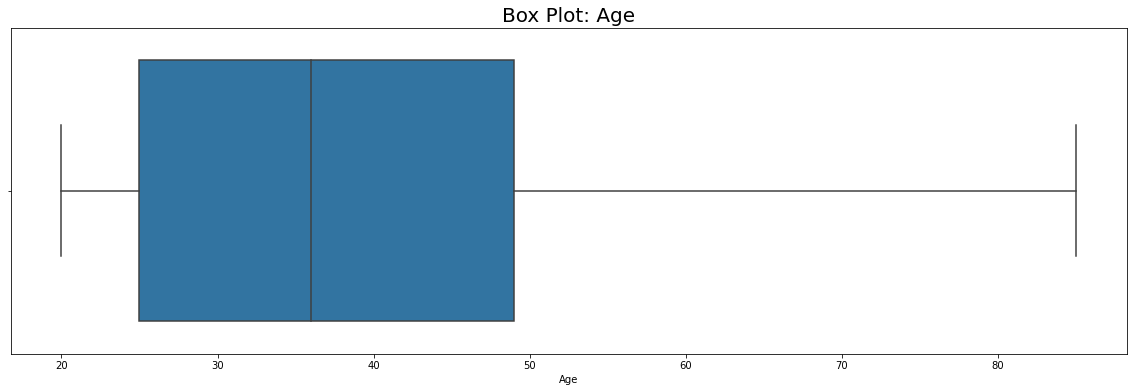

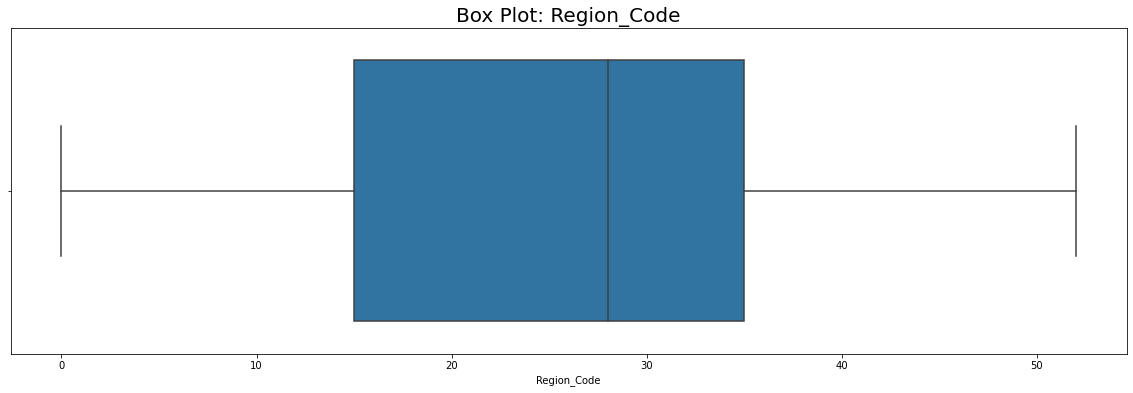

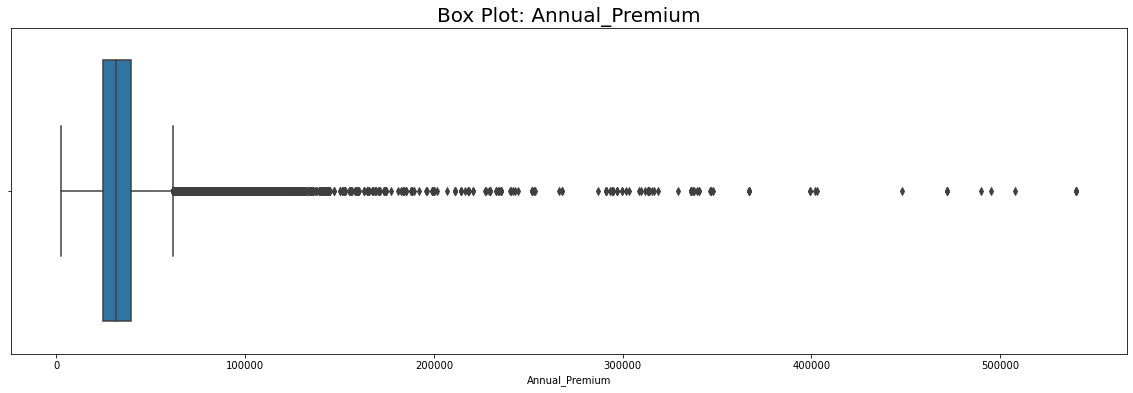

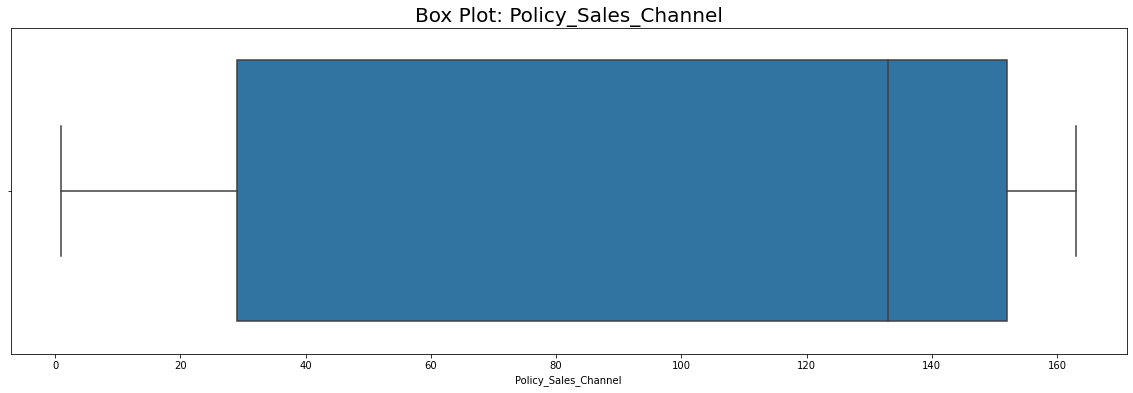

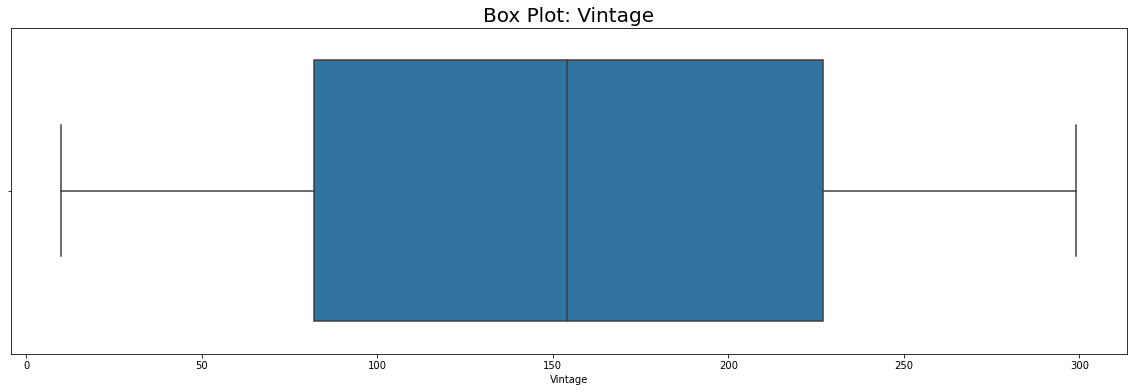

In [10]:
# box plots
for col in numeric_cols:
    plt.figure(figsize=(20, 6))
    sns.boxplot(x=col, data=train)
    plt.title("Box Plot: " + col, {'fontsize': 20})
    plt.xlabel(col)
    plt.show()

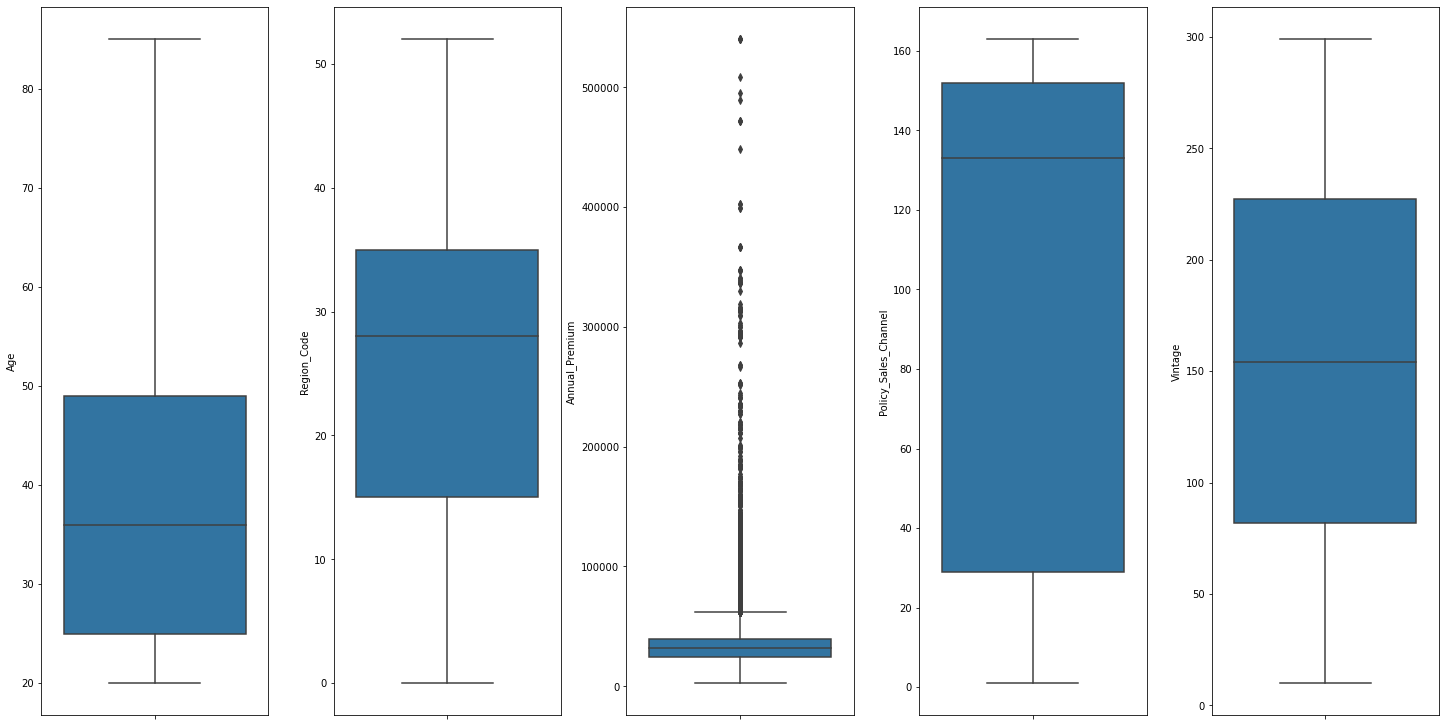

In [11]:
# box plots
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k, v in train[numeric_cols].items():
    sns.boxplot(y=k, data=train[numeric_cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

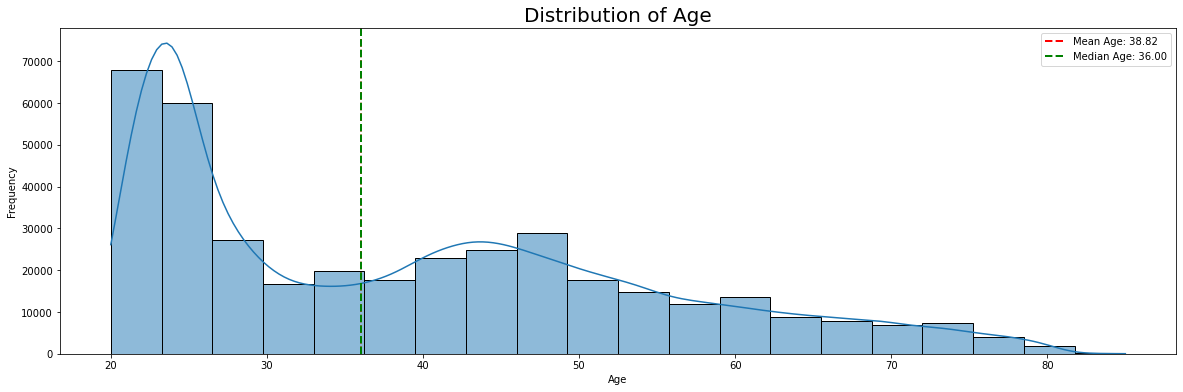

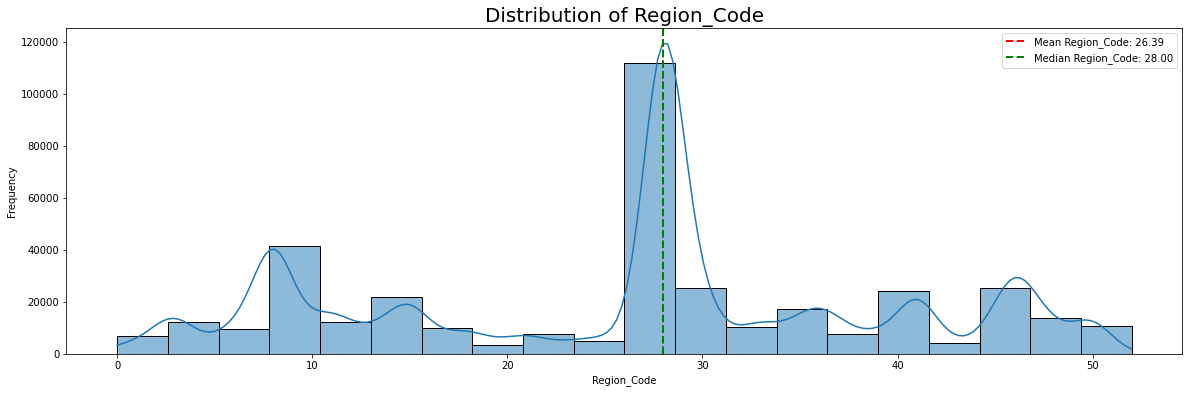

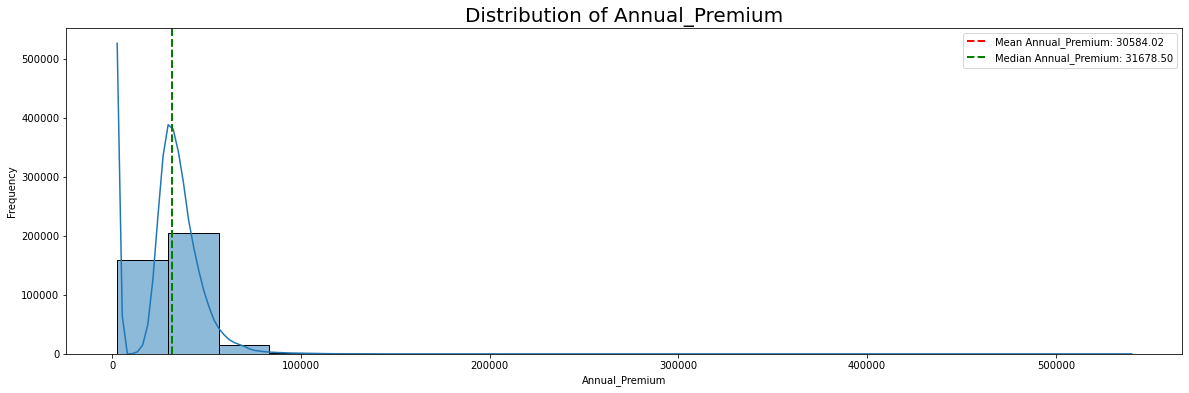

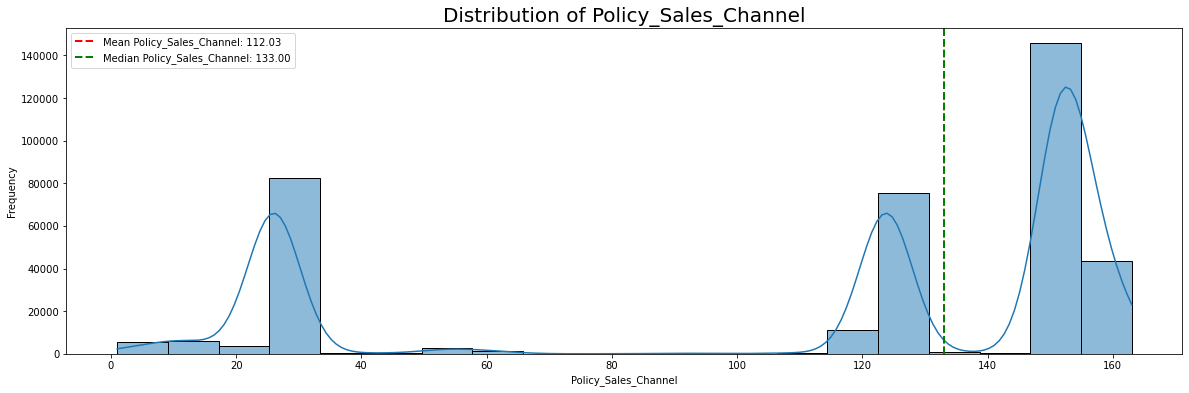

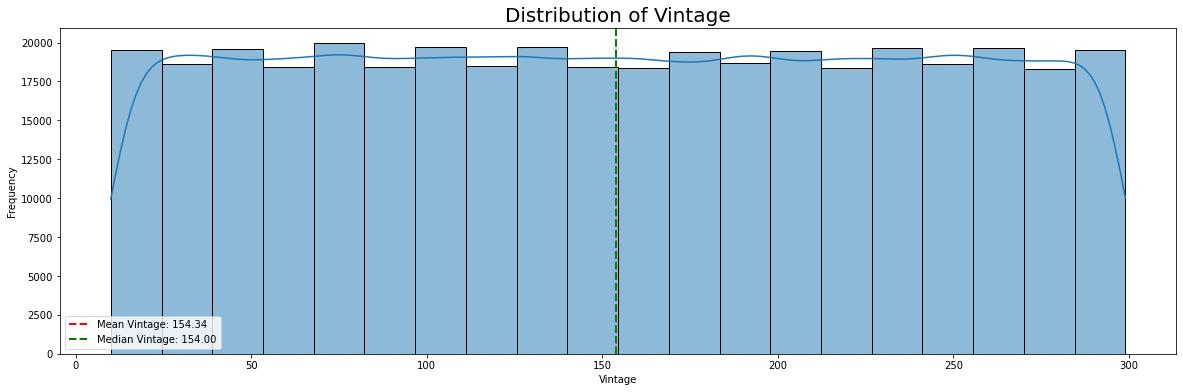

In [12]:
for col in numeric_cols:
    # Calculate summary statistics for numeric_cols
    mean_ = train[col].mean()
    median_ = train[col].median()

    # Create an age distribution plot (histogram)
    plt.figure(figsize=(20, 6))
    sns.histplot(train[col].dropna(), bins=20, kde=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + col, {'fontsize': 20})
    plt.axvline(median_,
                color='red',
                linestyle='dashed',
                linewidth=2,
                label=f'Mean {col}: {mean_:.2f}')
    plt.axvline(median_,
                color='green',
                linestyle='dashed',
                linewidth=2,
                label=f'Median {col}: {median_:.2f}')
    plt.legend()
    plt.show()

    # print(f"Mean Price: {price_mean:.2f}")
    # print(f"Median Price: {price_median:.2f}")

### Cathegorical

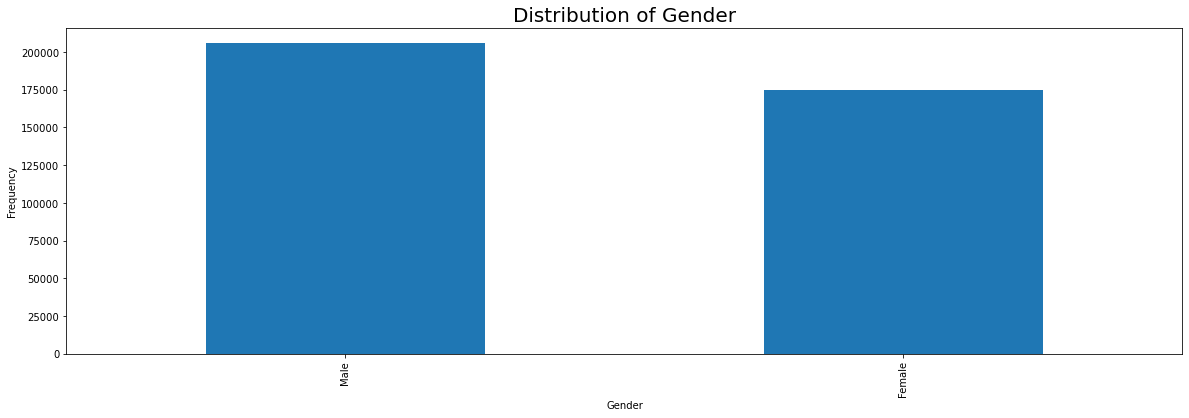

Male     0.541
Female   0.459
Name: Gender, dtype: float64


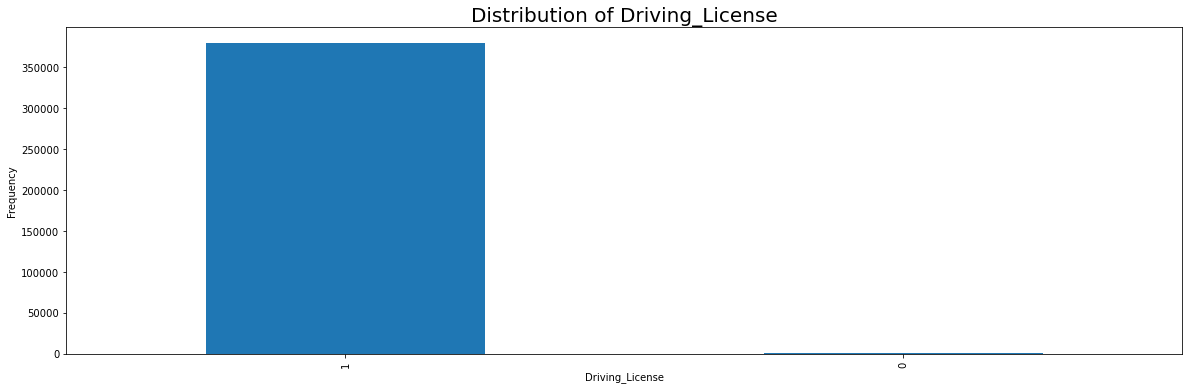

1   0.998
0   0.002
Name: Driving_License, dtype: float64


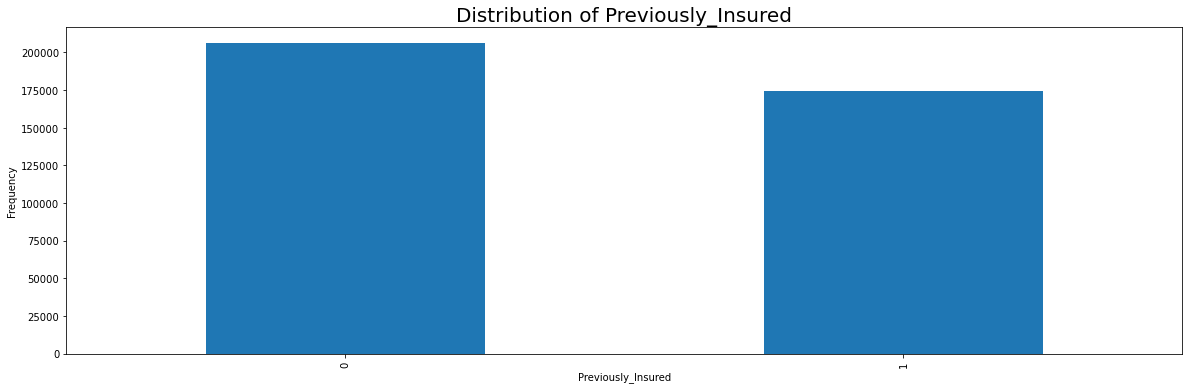

0   0.542
1   0.458
Name: Previously_Insured, dtype: float64


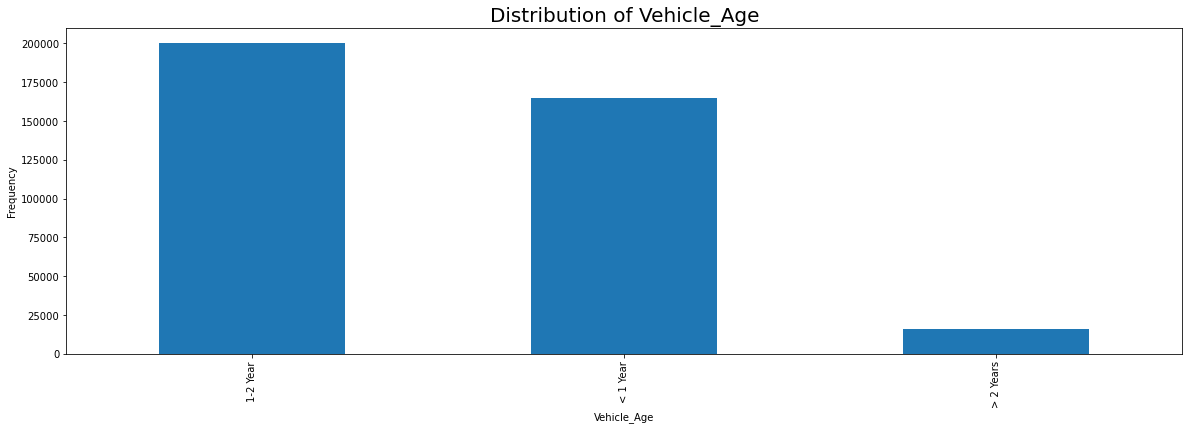

1-2 Year    0.526
< 1 Year    0.432
> 2 Years   0.042
Name: Vehicle_Age, dtype: float64


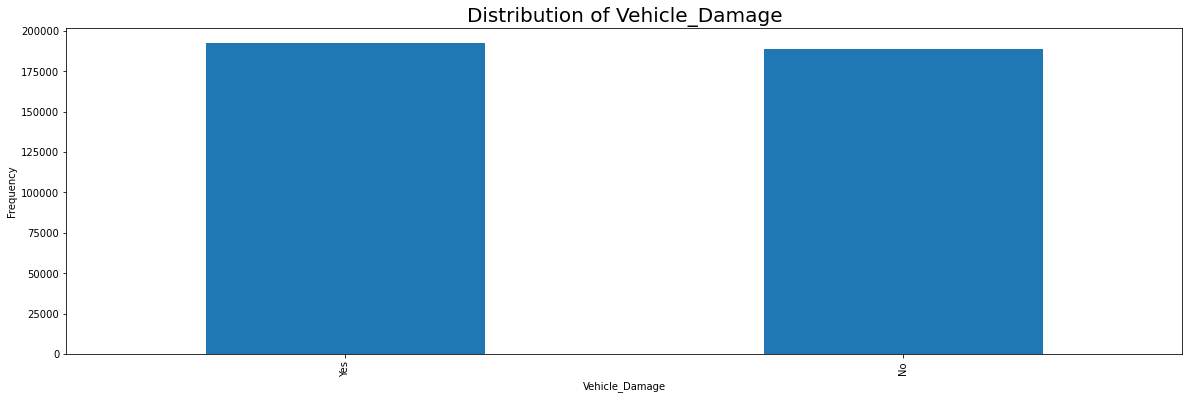

Yes   0.505
No    0.495
Name: Vehicle_Damage, dtype: float64


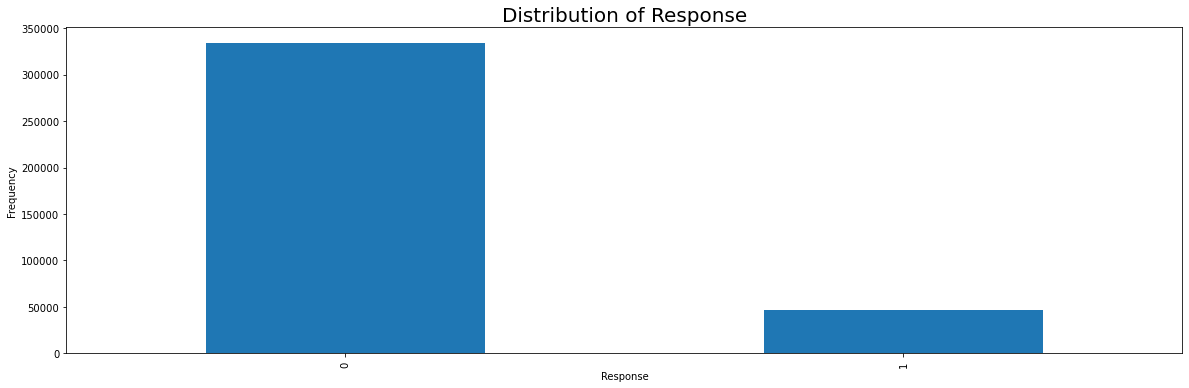

0   0.877
1   0.123
Name: Response, dtype: float64


In [13]:
for col in cat_cols:
    plt.figure(figsize=(20, 6))
    train[col].value_counts().plot(kind='bar')
    plt.title(f"Distribution of {col}", {'fontsize': 20})
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()
    print(train[col].value_counts(normalize=True))

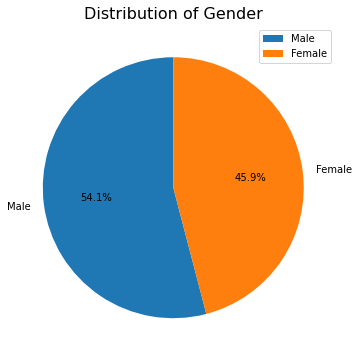

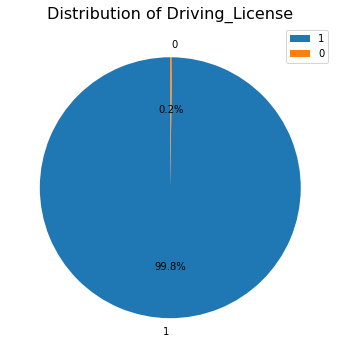

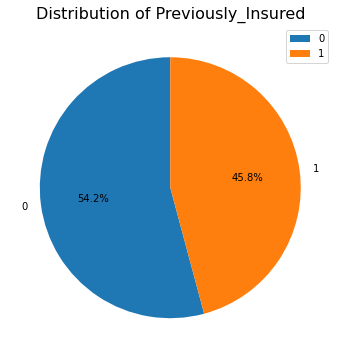

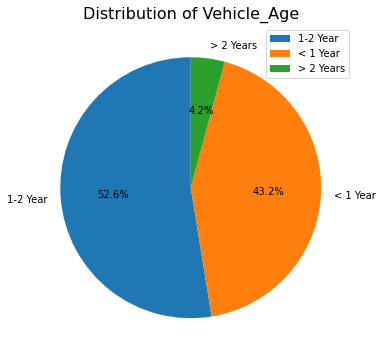

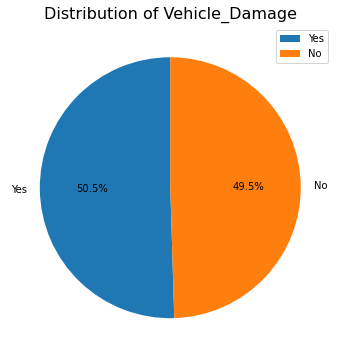

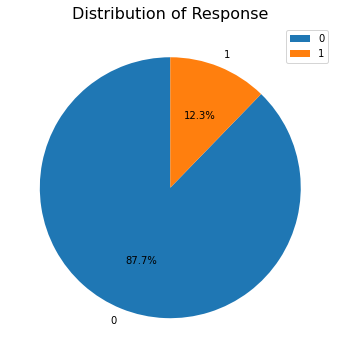

In [14]:
for col in cat_cols:
    plt.figure(figsize=(6, 6))
    train[col].value_counts().plot(kind='pie',
                                   autopct='%1.1f%%',
                                   startangle=90)
    plt.legend()
    plt.title(f"Distribution of {col}", {'fontsize': 16})
    plt.ylabel('')
    plt.show()

## Bivariate

In [15]:
# # Ничего не показывает для категориального таргета
# sns.pairplot(data=train, hue='Response');

<AxesSubplot:>

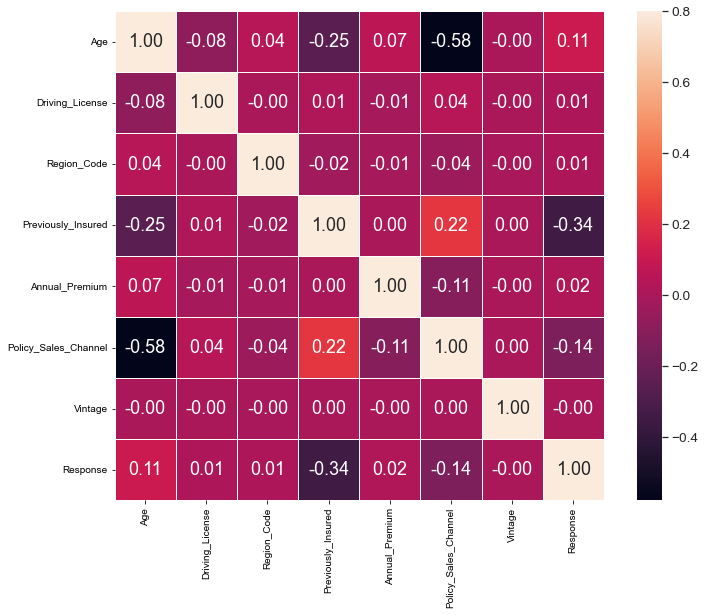

In [16]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
sns.heatmap(corrmat,
            annot=True,
            vmax=.8,
            square=True,
            fmt='.2f',
            annot_kws={'size': 18},
            linewidths=0.5)

<Figure size 864x648 with 0 Axes>

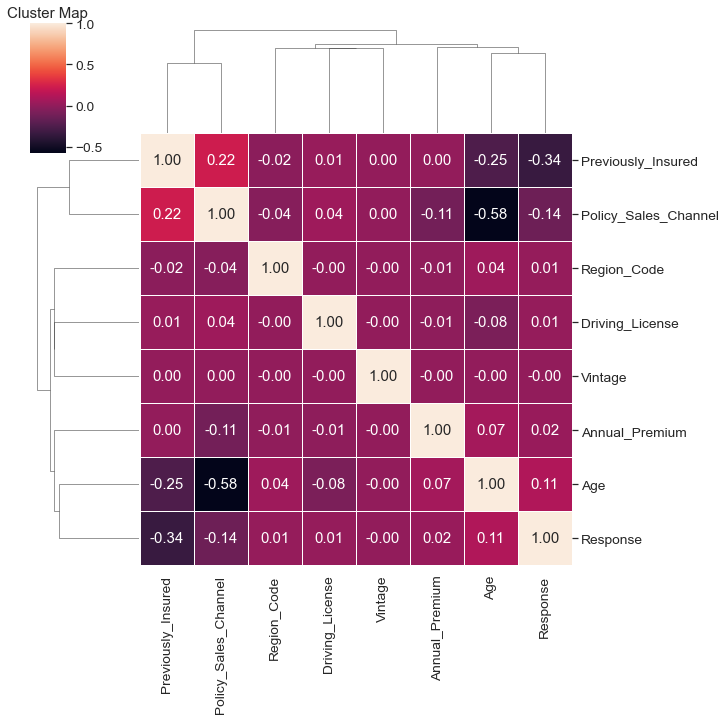

In [17]:
plt.figure(figsize=(12, 9))
# sns.set(font_scale=1.3)
# sns.clustermap(df.corr(), annot=True, fmt='.2f', linewidths=0.5)
sns.clustermap(train.corr(), annot=True, fmt='.2f', linewidths=0.5)
plt.title("Cluster Map")
plt.show()

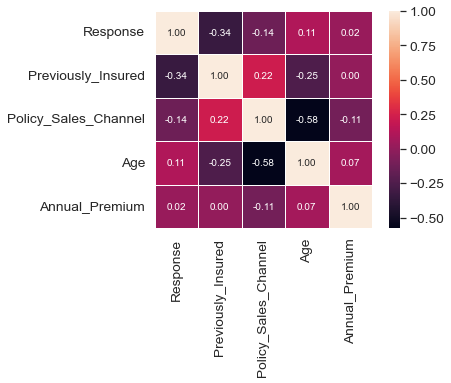

In [18]:
# Топ 5 зависимых в абсолюте
k = 5
cols = corrmat.abs().nlargest(k, 'Response')['Response'].index
cm = np.corrcoef(train[cols].values.T)

# f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 linewidths=0.5,
                 yticklabels=cols.values,
                 xticklabels=cols.values)

plt.show()

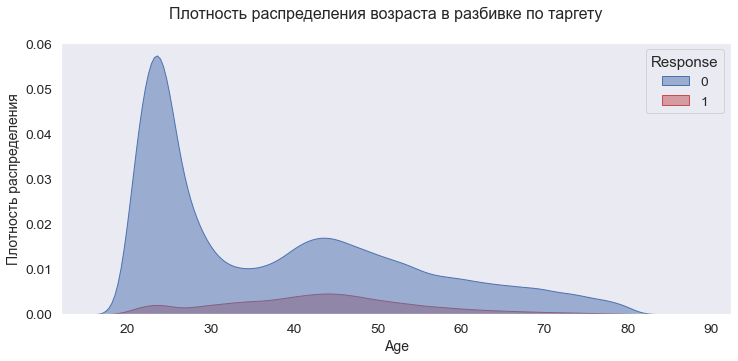

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Плотность распределения возраста в разбивке по таргету',
             fontsize=16)
kdeplot_t = sns.kdeplot(train['Age'],
                        palette=['b', 'r'],
                        alpha=.5,
                        shade=True,
                        hue=train['Response'])
plt.grid()
kdeplot_t.set_xlabel("Age", fontsize=14)
kdeplot_t.set_ylabel("Плотность распределения", fontsize=14)
plt.show()

,count
Gender,
Female,174902
Male,205938


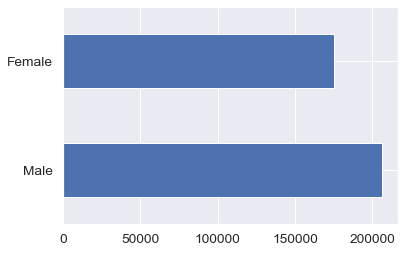

______________________________________________________________________


,count
Driving_License,
0,812
1,380028


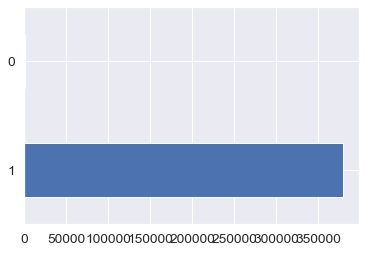

______________________________________________________________________


,count
Previously_Insured,
0,206336
1,174504


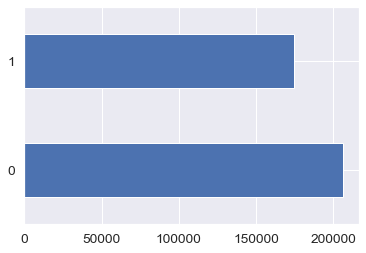

______________________________________________________________________


,count
Vehicle_Age,
1-2 Year,200167
< 1 Year,164671
> 2 Years,16002


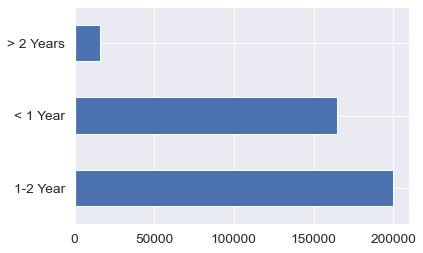

______________________________________________________________________


,count
Vehicle_Damage,
No,188563
Yes,192277


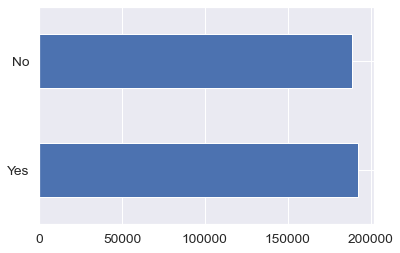

______________________________________________________________________


,count
Response,
0,334155
1,46685


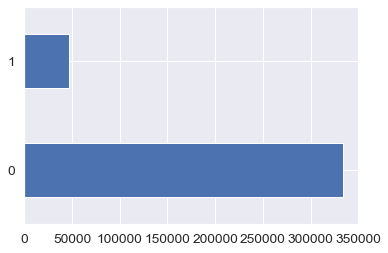

______________________________________________________________________


In [20]:
# no_num_cols = bin_cols + cat_cols

for col in cat_cols:
    display(train.groupby(col)['Response'].agg(['count']))
    train[col].value_counts().plot.barh()
    plt.show()
    print("_"*70)

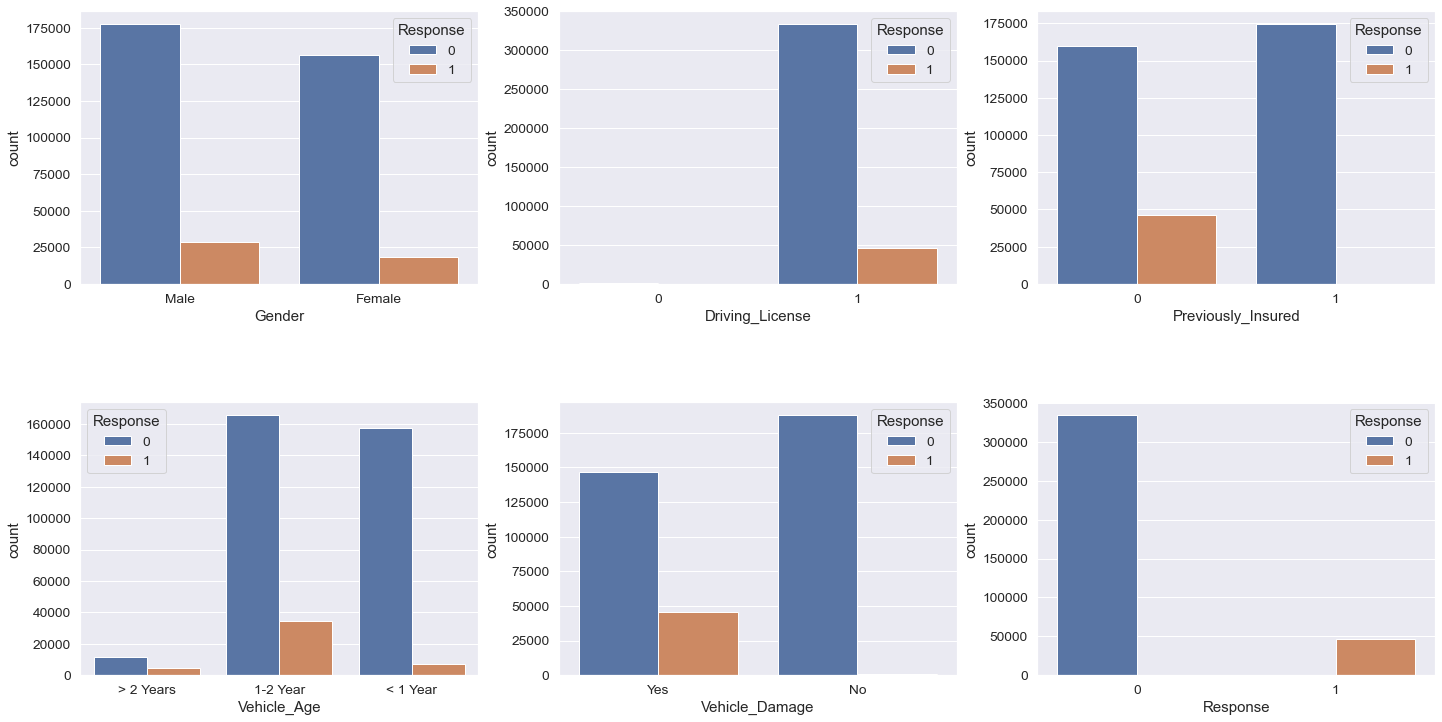

In [21]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(cat_cols):
    sns.countplot(data=train, x=train[k], hue=train['Response'], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

## Data preprocessing for model

In [22]:
df = train.copy().reset_index()
df = df.drop(['index'], axis=1)

In [23]:
# # Кодирование переменных
# df[''] = df['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

# Изменение типа данных
df['Region_Code'] = df['Region_Code'].astype('int')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int')

In [24]:
# Dummy
df = pd.get_dummies(data=df, columns=['Vehicle_Age'])
df = df.rename(
    columns={
        "Vehicle_Age_1-2 Year": "Vehicle_Age_1_2_Year",
        "Vehicle_Age_< 1 Year": "Vehicle_Age_less_1_Year",
        "Vehicle_Age_> 2 Years": "Vehicle_Age_more_2_Years"
    })
df.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
       'Response', 'Vehicle_Age_1_2_Year', 'Vehicle_Age_less_1_Year',
       'Vehicle_Age_more_2_Years'],
      dtype='object')

In [25]:
# Категоризация
# список с категориальными столбцами, но с целевым признаком
cat_feat = [
    'Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
    'Vehicle_Age_1_2_Year', 'Vehicle_Age_less_1_Year',
    'Vehicle_Age_more_2_Years', 'Vehicle_Damage', 'Policy_Sales_Channel'
]

# числовые признаки
num_feat = ['Age', 'Vintage']
df[num_feat] = df[num_feat].astype('int')

# переменные до десятых
float_feat = ['Annual_Premium']

In [26]:
# OneHotEncoder
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[cat_feat]).toarray()
encoded_df = pd.DataFrame(encoded_data,
                          columns=encoder.get_feature_names_out(cat_feat))

for col in encoded_df.columns:
    encoded_df[col] = encoded_df[col].astype('category')

df = pd.concat([df, encoded_df], axis=1)
df = df.drop(df[cat_feat], axis=1)

# Standard Scalar
scaler = StandardScaler()
df[num_feat] = scaler.fit_transform(df[num_feat])

# MinMaxScalar
scaler = MinMaxScaler()
df[float_feat] = scaler.fit_transform(df[float_feat])

df.head(3)

,Age,Annual_Premium,Vintage,Response,Gender_Male,Driving_License_1,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,...,Policy_Sales_Channel_152,Policy_Sales_Channel_153,Policy_Sales_Channel_154,Policy_Sales_Channel_155,Policy_Sales_Channel_156,Policy_Sales_Channel_157,Policy_Sales_Channel_158,Policy_Sales_Channel_159,Policy_Sales_Channel_160,Policy_Sales_Channel_163
0,0.334,0.070,0.749,1,1.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2.396,0.057,0.342,0,1.000,1.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.527,0.066,-1.522,1,1.000,1.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Модель

In [27]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report

In [28]:
X = df.drop(['Response'], axis=1)
y = df['Response']

In [63]:
from pandas.api.types import CategoricalDtype

# создадим списки для объекто-категориальных и числовых значений
cat, numeric = [], []
[
    cat.append(col) if isinstance(X[col].dtype, CategoricalDtype)
    or X[col].dtype == 'object' else numeric.append(col) for col in X.columns
];

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=random_state)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((266588, 216), (266588,), (114252, 216), (114252,))

In [31]:
# import optuna

# # LogisticRegression
# log_reg_params = {
#     'c': trial.suggest_loguniform('C', 0.001, 100),
#     'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
#     'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga', 'newton-cg']),
#     'max_iter': trial.suggest_int('max_iter', 100, 1000)
# }

# # RandomForestClassifier
# rsc = {
#     'criterion': trial.suggest_categorical('criterion', ['entropy', 'gini']),
#     'max_depth': trial.suggest_int('max_depth', 2, 10),
#     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 8),
#     'min_samples_split': trial.suggest_int('min_samples_split', 5, 10),
#     'n_estimators': [300]
#  }

# # DecisionTreeClassifier
# dtc_params = {
#     'max_depth': trial.suggest_int(1, 15)
# }

# # GradientBoostingClassifier
# gbc_params = {
#     'max_depth': trial.suggest_int('max_depth', 3, 10),
#     'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
#     'n_estimators': trial.suggest_int('n_estimators', 50, 300)
# }

# # LGBMClassifier
# clf_params = {
#     'objective': 'regression',
#     'boosting_type': 'gbdt',
# #     'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#     'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1)
# #     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
# #     'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
# #     'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
# #     'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.001, 10.0),
# #     'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.001, 10.0),
# #     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
# }

In [32]:
# Обновление списка с результатами моделирования
score_results = []

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold


def roc_auc_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = []
    for train, test in cv.split(X_train, y_train):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_train)[:, 1]
        score = roc_auc_score(y_train, y_pred)
        cv_scores.append(score)
    roc_auc = np.mean(cv_scores)
    return roc_auc


def FitPrintAndSaveModelResults(model, methodName):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_train)[:, 1]

    y_train_pred = model.predict(X_train)
    metrics_train_accuracy = accuracy_score(y_train, y_train_pred).round(6)
    metrics_train_precision = precision_score(y_train, y_train_pred, average='weighted').round(6)
    metrics_train_recall = recall_score(y_train, y_train_pred, average='weighted').round(6)
    metrics_train_f1 = f1_score(y_train, y_train_pred, average='weighted').round(6)
    metrics_train_roc_auc = roc_auc_score(y_train, y_train_pred, average='weighted').round(6)

    print(f"Train Accuracy: {metrics_train_accuracy:.3f}")
    print(f"Train Precision: {metrics_train_precision:.3f}")
    print(f"Train Recall: {metrics_train_recall:.3f}")
    print(f"Train F1 Score: {metrics_train_f1:.3f}")
    print(f"Train ROC-AUC: {metrics_train_roc_auc:.3f}")
    print()

    y_test_pred = model.predict(X_test)
    metrics_test_accuracy = accuracy_score(y_test, y_test_pred).round(6)
    metrics_test_precision = precision_score(y_test, y_test_pred, average='weighted').round(6)
    metrics_test_recall = recall_score(y_test, y_test_pred, average='weighted').round(6)
    metrics_test_f1 = f1_score(y_test, y_test_pred, average='weighted').round(6)
    metrics_test_roc_auc = roc_auc_score(y_test, y_test_pred, average='weighted').round(6)

    print(f"Test Accuracy: {metrics_test_accuracy:.3f}")
    print(f"Test Precision: {metrics_test_precision:.3f}")
    print(f"Test Recall: {metrics_test_recall:.3f}")
    print(f"Test F1 Score: {metrics_test_f1:.3f}")
    print(f"Test ROC-AUC: {metrics_test_roc_auc:.3f}")
    print()

    #     roc_auc_cross_val = roc_auc_cv(model)
    #     print(f"ROC-AUC cross-validation score: {roc_auc_cross_val:.3f}")

    score_results.append({
        # 'model': model,
        'method': methodName,
        'result_train_accuracy': metrics_train_accuracy,
        'result_train_precision': metrics_train_precision,
        'result_train_recall': metrics_train_recall,
        'result_train_f1': metrics_train_f1,
        'result_train_roc_auc': metrics_train_roc_auc,
        'result_test_accuracy': metrics_test_accuracy,
        'result_test_precision': metrics_test_precision,
        'result_test_recall': metrics_test_recall,
        'result_test_f1': metrics_test_f1,
        'result_test_roc_auc': metrics_test_roc_auc,
        # 'roc_auc_cross_val': roc_auc_cross_val
    })

In [34]:
from sklearn.dummy import DummyClassifier

# Проверика модели на адекватность
dummy = DummyClassifier(strategy='most_frequent', random_state=random_state)

FitPrintAndSaveModelResults(dummy, 'DummyClassifier')

Train Accuracy: 0.877
Train Precision: 0.769
Train Recall: 0.877
Train F1 Score: 0.820
Train ROC-AUC: 0.500

Test Accuracy: 0.878
Test Precision: 0.771
Test Recall: 0.878
Test F1 Score: 0.821
Test ROC-AUC: 0.500



              precision    recall  f1-score   support

           0       0.88      1.00      0.94    100342
           1       0.00      0.00      0.00     13910

    accuracy                           0.88    114252
   macro avg       0.44      0.50      0.47    114252
weighted avg       0.77      0.88      0.82    114252



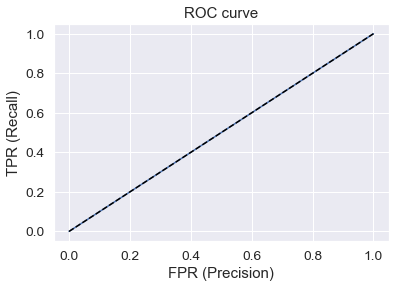

Area under curve (AUC): 0.5


In [35]:
# classification_report
y_pred = dummy.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC curve
y_pred = dummy.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

### Class weight: balanced

In [36]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression
log_reg = LogisticRegression(random_state=random_state,
                             class_weight='balanced')

FitPrintAndSaveModelResults(log_reg, 'LogisticRegression')

Train Accuracy: 0.694
Train Precision: 0.900
Train Recall: 0.694
Train F1 Score: 0.746
Train ROC-AUC: 0.798

Test Accuracy: 0.693
Test Precision: 0.900
Test Recall: 0.693
Test F1 Score: 0.746
Test ROC-AUC: 0.798



              precision    recall  f1-score   support

           0       0.99      0.66      0.79    100342
           1       0.28      0.94      0.43     13910

    accuracy                           0.69    114252
   macro avg       0.63      0.80      0.61    114252
weighted avg       0.90      0.69      0.75    114252



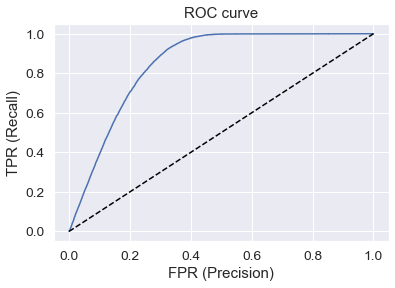

Area under curve (AUC): 0.849126990365846


In [37]:
# classification_report
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC-curve
y_pred = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [38]:
# from sklearn.ensemble import RandomForestClassifier

# # RandomForestClassifier
# rsc = RandomForestClassifier(random_state=random_state, class_weight='balanced')

# FitPrintAndSaveModelResults(rsc,'RandomForestClassifier')

In [39]:
# # classification_report
# y_pred = rsc.predict(X_test)
# print(classification_report(y_test, y_pred))

# # ROC-curve
# y_pred = rsc.predict_proba(X_test)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred)

# plt.title('ROC curve')
# plt.xlabel('FPR (Precision)')
# plt.ylabel('TPR (Recall)')

# plt.plot(fpr, tpr)
# plt.plot((0, 1), ls='dashed', color='black')
# plt.show()
# print('Area under curve (AUC):', auc(fpr, tpr))

In [40]:
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=random_state,
                             class_weight='balanced')

FitPrintAndSaveModelResults(dtc, 'DecisionTreeClassifier')

Train Accuracy: 1.000
Train Precision: 1.000
Train Recall: 1.000
Train F1 Score: 1.000
Train ROC-AUC: 1.000

Test Accuracy: 0.825
Test Precision: 0.828
Test Recall: 0.825
Test F1 Score: 0.826
Test ROC-AUC: 0.598



              precision    recall  f1-score   support

           0       0.90      0.90      0.90    100342
           1       0.29      0.30      0.29     13910

    accuracy                           0.83    114252
   macro avg       0.60      0.60      0.60    114252
weighted avg       0.83      0.83      0.83    114252



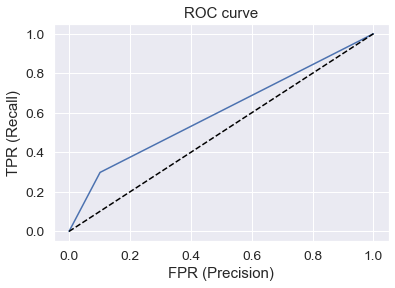

Area under curve (AUC): 0.5982832465663334


In [41]:
# classification_report
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC-curve
y_pred = dtc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=random_state)

FitPrintAndSaveModelResults(gbc, 'GradientBoostingClassifier')

Train Accuracy: 0.877
Train Precision: 0.855
Train Recall: 0.877
Train F1 Score: 0.820
Train ROC-AUC: 0.500

Test Accuracy: 0.878
Test Precision: 0.792
Test Recall: 0.878
Test F1 Score: 0.821
Test ROC-AUC: 0.500



              precision    recall  f1-score   support

           0       0.88      1.00      0.94    100342
           1       0.17      0.00      0.00     13910

    accuracy                           0.88    114252
   macro avg       0.52      0.50      0.47    114252
weighted avg       0.79      0.88      0.82    114252



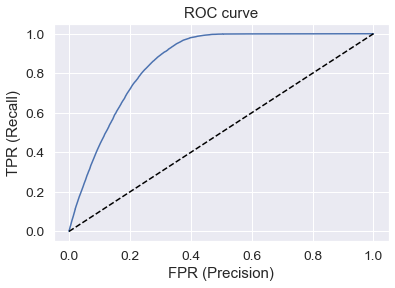

Area under curve (AUC): 0.8568954441804714


In [43]:
# classification_report
y_pred = gbc.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC curve
y_pred = gbc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [44]:
import lightgbm as lgb

# LGBMClassifier
clf = lgb.LGBMClassifier(class_weight='balanced', random_state=random_state)

FitPrintAndSaveModelResults(clf, 'LGBMClassifier')

[LightGBM] [Info] Number of positive: 32775, number of negative: 233813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 266588, number of used features: 148
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train Accuracy: 0.704
Train Precision: 0.901
Train Recall: 0.704
Train F1 Score: 0.754
Train ROC-AUC: 0.806

Test Accuracy: 0.701
Test Precision: 0.900
Test Recall: 0.701
Test F1 Score: 0.753
Test ROC-AUC: 0.801



              precision    recall  f1-score   support

           0       0.99      0.67      0.80    100342
           1       0.28      0.93      0.43     13910

    accuracy                           0.70    114252
   macro avg       0.63      0.80      0.61    114252
weighted avg       0.90      0.70      0.75    114252



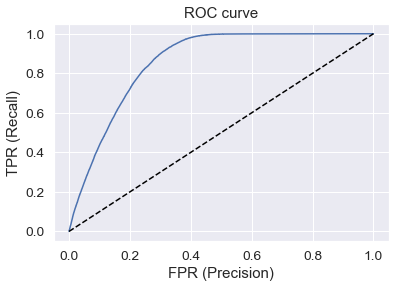

Area under curve (AUC): 0.858024376545944


In [45]:
# classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC curve
y_pred = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [46]:
# from catboost import CatBoostClassifier

# # CatBoostClassifier
# cbc = CatBoostClassifier(
#         auto_class_weights='Balanced',
#         cat_features=cat,
#         eval_metric='AUC',
#         random_seed = random_state)

# FitPrintAndSaveModelResults(cbc,'CatBoostClassifier')

In [47]:
# # classification_report
# y_pred = cbc.predict(X_test)
# print(classification_report(y_test, y_pred))

# # ROC curve
# y_pred = cbc.predict_proba(X_test)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred)

# plt.title('ROC curve')
# plt.xlabel('FPR (Precision)')
# plt.ylabel('TPR (Recall)')

# plt.plot(fpr, tpr)
# plt.plot((0, 1), ls='dashed', color='black')
# plt.show()
# print('Area under curve (AUC):', auc(fpr, tpr))

### Class weight: unbalanced

In [48]:
from sklearn.linear_model import LogisticRegression

# LogisticRegression
lin_reg = LogisticRegression(random_state=random_state)

FitPrintAndSaveModelResults(lin_reg, 'LogisticRegression_unb')

Train Accuracy: 0.877
Train Precision: 0.816
Train Recall: 0.877
Train F1 Score: 0.820
Train ROC-AUC: 0.501

Test Accuracy: 0.878
Test Precision: 0.809
Test Recall: 0.878
Test F1 Score: 0.822
Test ROC-AUC: 0.501



              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100342
           1       0.31      0.00      0.00     13910

    accuracy                           0.88    114252
   macro avg       0.59      0.50      0.47    114252
weighted avg       0.81      0.88      0.82    114252



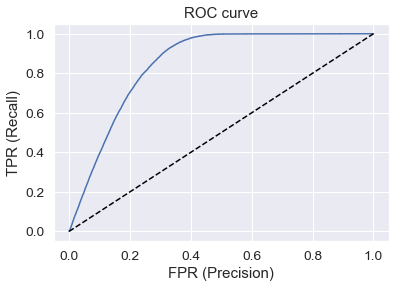

Area under curve (AUC): 0.8493490719682609


In [49]:
# classification_report
y_pred = lin_reg.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC curve
y_pred = lin_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [50]:
# from sklearn.ensemble import RandomForestClassifier

# # RandomForestClassifier
# rsc = RandomForestClassifier(random_state=random_state)

# FitPrintAndSaveModelResults(rsc,'RandomForestClassifier_unb')

In [51]:
# # classification_report
# y_pred = rsc.predict(X_test)
# print(classification_report(y_test, y_pred))

# # ROC curve
# y_pred = rsc.predict_proba(X_test)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred)

# plt.title('ROC curve')
# plt.xlabel('FPR (Precision)')
# plt.ylabel('TPR (Recall)')

# plt.plot(fpr, tpr)
# plt.plot((0, 1), ls='dashed', color='black')
# plt.show()
# print('Area under curve (AUC):', auc(fpr, tpr))

In [52]:
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=random_state)

FitPrintAndSaveModelResults(dtc, 'DecisionTreeClassifier_unb')

Train Accuracy: 1.000
Train Precision: 1.000
Train Recall: 1.000
Train F1 Score: 1.000
Train ROC-AUC: 1.000

Test Accuracy: 0.828
Test Precision: 0.828
Test Recall: 0.828
Test F1 Score: 0.828
Test ROC-AUC: 0.599



              precision    recall  f1-score   support

           0       0.90      0.90      0.90    100342
           1       0.29      0.30      0.30     13910

    accuracy                           0.83    114252
   macro avg       0.60      0.60      0.60    114252
weighted avg       0.83      0.83      0.83    114252



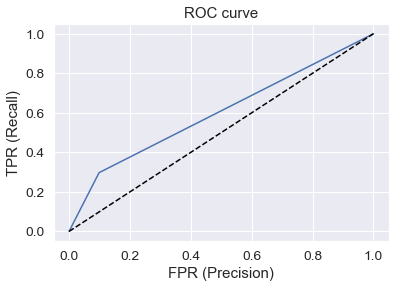

Area under curve (AUC): 0.5992750200496904


In [53]:
# classification_report
y_pred = dtc.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC curve
y_pred = dtc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [54]:
import lightgbm as lgb

# LGBMClassifier
clf = lgb.LGBMClassifier(random_state=random_state)

FitPrintAndSaveModelResults(clf, 'LGBMClassifier_unb')

[LightGBM] [Info] Number of positive: 32775, number of negative: 233813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 900
[LightGBM] [Info] Number of data points in the train set: 266588, number of used features: 148
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122943 -> initscore=-1.964856
[LightGBM] [Info] Start training from score -1.964856
Train Accuracy: 0.878
Train Precision: 0.854
Train Recall: 0.878
Train F1 Score: 0.822
Train ROC-AUC: 0.504

Test Accuracy: 0.878
Test Precision: 0.831
Test Recall: 0.878
Test F1 Score: 0.823
Test ROC-AUC: 0.503



              precision    recall  f1-score   support

           0       0.88      1.00      0.94    100342
           1       0.49      0.01      0.01     13910

    accuracy                           0.88    114252
   macro avg       0.68      0.50      0.47    114252
weighted avg       0.83      0.88      0.82    114252



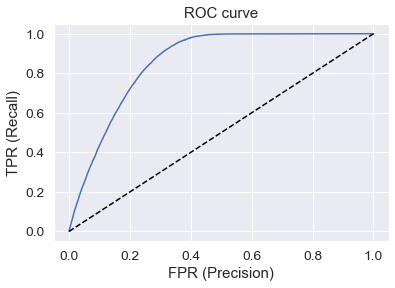

Area under curve (AUC): 0.8577464460474007


In [55]:
# classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# ROC curve
y_pred = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.title('ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0, 1), ls='dashed', color='black')
plt.show()
print('Area under curve (AUC):', auc(fpr, tpr))

In [56]:
# from catboost import CatBoostClassifier

# # CatBoostClassifier
# cbc = CatBoostClassifier(
#         cat_features=cat,
#         eval_metric='AUC',
#         random_seed = random_state)

# FitPrintAndSaveModelResults(cbc,'CatBoostClassifier_unb')

In [57]:
# # classification_report
# y_pred = cbc.predict(X_test)
# print(classification_report(y_test, y_pred))

# # ROC curve
# y_pred = cbc.predict_proba(X_test)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred)

# plt.title('ROC curve')
# plt.xlabel('FPR (Precision)')
# plt.ylabel('TPR (Recall)')

# plt.plot(fpr, tpr)
# plt.plot((0, 1), ls='dashed', color='black')
# plt.show()
# print('Area under curve (AUC):', auc(fpr, tpr))

### Optuna, class weight unbalanced

In [1]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, roc_auc_score


# def objective1(trial):
#     c = trial.suggest_loguniform('C', 0.001, 100)
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
#     solver = trial.suggest_categorical(
#         'solver', ['liblinear', 'lbfgs', 'saga', 'newton-cg'])
#     max_iter = trial.suggest_int('max_iter', 100, 1000)

#     # Create the logistic regression model with the hyperparameters
#     model = LogisticRegression(C=c,
#                                penalty=penalty,
#                                solver=solver,
#                                max_iter=max_iter)

#     # Evaluate the model using cross-validation with ROC-AUC scoring
#     roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
#     scores = cross_val_score(model, X, y, cv=5, scoring=roc_auc_scorer)

#     # Return the mean ROC-AUC score as the objective value
#     return scores.mean()

In [59]:
# # cоздаем объект исследования
# study_log_reg = optuna.create_study(
#     study_name="LogisticRegression Optuna Optimization with Cross Validation",
#     direction="maximize",
#     storage='sqlite:///ex.db',
#     load_if_exists=True,
# )

# # ищем лучшую комбинацию гиперпараметров n_trials раз
# study_log_reg.optimize(objective1, n_trials=20, n_jobs=-1)

# # выводим результаты на обучающей выборке
# print("Наилучшие значения гиперпараметров {}".format(
#     study_dec_tree.best_params))
# print("ROC-AUC на обучающем наборе: {:.3f}".format(study_dec_tree.best_value))

In [60]:
# # LogisticRegression
# lin_reg_opt = LogisticRegression(**study_log_reg.best_params,
#                                  random_state=random_state)

# FitPrintAndSaveModelResults(lin_reg_opt, 'LogisticRegression_unb')

In [61]:
# # classification_report
# y_pred = lin_reg_opt.predict(X_test)
# print(classification_report(y_test, y_pred))

# # ROC curve
# y_pred = lin_reg_opt.predict_proba(X_test)[:, 1]
# fpr, tpr, _ = roc_curve(y_test, y_pred)

# plt.title('ROC curve')
# plt.xlabel('FPR (Precision)')
# plt.ylabel('TPR (Recall)')

# plt.plot(fpr, tpr)
# plt.plot((0, 1), ls='dashed', color='black')
# plt.show()
# print('Area under curve (AUC):', auc(fpr, tpr))

NameError: name 'lin_reg_opt' is not defined

In [62]:
resultScoreData = pd.DataFrame(score_results).set_index('method').sort_values(by='result_test_roc_auc', ascending=False)

resultScoreData

,result_train_accuracy,result_train_precision,result_train_recall,result_train_f1,result_train_roc_auc,result_test_accuracy,result_test_precision,result_test_recall,result_test_f1,result_test_roc_auc
method,,,,,,,,,,
LGBMClassifier,0.704,0.901,0.704,0.754,0.806,0.701,0.900,0.701,0.753,0.801
LogisticRegression,0.694,0.900,0.694,0.746,0.798,0.693,0.900,0.693,0.746,0.798
DecisionTreeClassifier_unb,1.000,1.000,1.000,1.000,1.000,0.828,0.828,0.828,0.828,0.599
DecisionTreeClassifier,1.000,1.000,1.000,1.000,1.000,0.825,0.828,0.825,0.826,0.598
LGBMClassifier_unb,0.878,0.854,0.878,0.822,0.504,0.878,0.831,0.878,0.823,0.503
LogisticRegression_unb,0.877,0.816,0.877,0.820,0.501,0.878,0.809,0.878,0.822,0.501
GradientBoostingClassifier,0.877,0.855,0.877,0.820,0.500,0.878,0.792,0.878,0.821,0.500
DummyClassifier,0.877,0.769,0.877,0.820,0.500,0.878,0.771,0.878,0.821,0.500
